In [2]:
#| default_exp datasets
!pip install -q miniai

In [1]:
#|export
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

/Users/bytedance/venv/lib/python3.13/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
logging.disable(logging.WARNING)

## Hugging Face Datasets

In [9]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

In [6]:
ds_builder.info.features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])}

In [7]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31049107.0, num_examples=60000, shard_lengths=None, original_shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5192560.0, num_examples=10000, shard_lengths=None, original_shard_lengths=None, dataset_name=None)}

In [8]:
dsd = load_dataset(name)
dsd

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [10]:
train,test = dsd['train'],dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [11]:
x,y = ds_builder.info.features

In [12]:
x,y

('image', 'label')

In [13]:
x,y = 'image','label'
img = train[0][x]
img

In [14]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [15]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [16]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [17]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [19]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

In [27]:
# 演示使用train的前5条数据通过collate_fn处理
# 从train数据集中获取前5个样本作为列表
batch_items = [train[i] for i in range(5)]
print(f"batch_items: {batch_items}")

# 使用collate_fn处理这个batch
result = collate_fn(batch_items)

# 查看结果
print(f"Images shape: {result[x].shape}")  # 应该是 [5, 1, 28, 28]
print(f"Labels: {result[y]}")  # 应该是 tensor([9, 0, 0, 3, 0])
print(f"\nFirst image tensor shape: {result[x][0].shape}")
print(f"First label: {result[y][0]}")

batch_items: [{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x307922D50>, 'label': 9}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x125D70B90>, 'label': 0}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x125BEB110>, 'label': 0}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x125BEAFD0>, 'label': 3}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x307AE1950>, 'label': 0}]
Images shape: torch.Size([5, 1, 28, 28])
Labels: tensor([9, 0, 0, 3, 0])

First image tensor shape: torch.Size([1, 28, 28])
First label: 9


In [28]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [29]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [30]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [31]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [32]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [33]:
transformi = inplace(_transformi)

In [35]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [36]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [37]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [38]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

In [39]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [40]:
d = D()
ig(d)

(1, 3)

In [41]:
list(tdsf.features)

['image', 'label']

In [42]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [44]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [45]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

## Plotting images

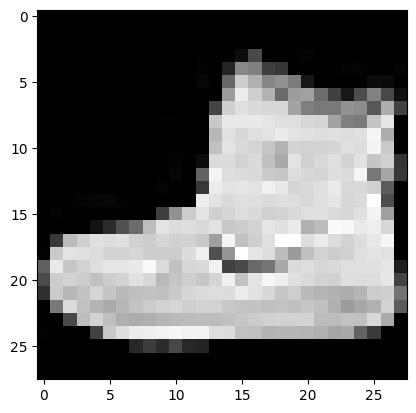

In [46]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [47]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [48]:
help(show_image)

Help on function show_image in module __main__:

show_image(
    im,
    ax=None,
    figsize=None,
    title=None,
    noframe=True,
    *,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    colorizer=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None
)
    Show a PIL or PyTorch image on `ax`.



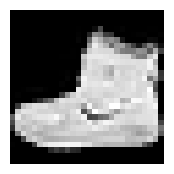

In [49]:
show_image(img, figsize=(2,2));

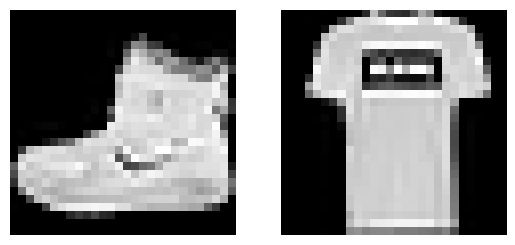

In [50]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [51]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [52]:
from nbdev.showdoc import show_doc

In [53]:
show_doc(subplots)

---

### subplots

```python

def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    sharex:bool | Literal['none', 'all', 'row', 'col']=False,
    sharey:bool | Literal['none', 'all', 'row', 'col']=False, squeeze:bool=True,
    width_ratios:Sequence[float] | None=None, height_ratios:Sequence[float] | None=None,
    subplot_kw:dict[str, Any] | None=None, gridspec_kw:dict[str, Any] | None=None, kwargs:VAR_KEYWORD
):


```

*A figure and set of subplots to display images of `imsize` inches*

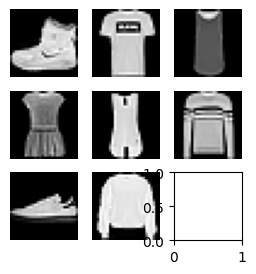

In [54]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [55]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

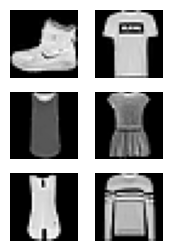

In [56]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [57]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [58]:
yb = b['label']
lbls = yb[:8]

In [59]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

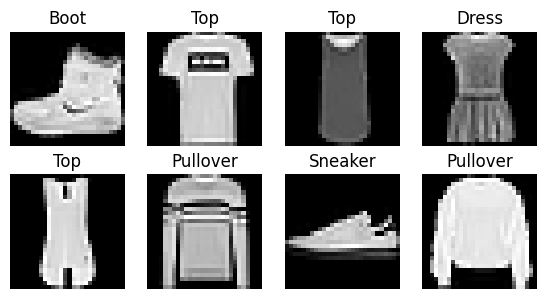

In [60]:
show_images(imgs, imsize=1.7, titles=titles)

In [61]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()